# TEMA 1 ML

In [4]:
try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import sys
    import io
    import os
    import zipfile
    import mnist_reader
    import cv2
    from PIL import Image
    from skimage.transform import resize
    from skimage.feature import hog
    from skimage.color import rgb2gray
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    from joblib import Parallel, delayed
    from sklearn.feature_selection import SelectPercentile, f_classif
    import seaborn as sns
    from sklearn.calibration import LabelEncoder
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.linear_model import LogisticRegression
    from sklearn.svm import SVC
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, ConfusionMatrixDisplay
    from sklearn.metrics import make_scorer, precision_score
    from xgboost import XGBClassifier
except ImportError:
    print("Installing required packages")
    import sys
    !{sys.executable} -m pip install opencv-python pandas numpy matplotlib seaborn scikit-learn scikit-image xgboost

# FASHION-MNIST

In [21]:
sys.path.append(os.path.abspath("./fashion-mnist/utils"))
data_path = os.path.abspath("./fashion-mnist/data/fashion")

if not os.path.exists('./features/'):
    os.makedirs('./features/fashion/hog/')
    os.makedirs('./features/fashion/pca/')
    os.makedirs('./features/fruits/hog/')
    os.makedirs('./features/fruits/orb/')

def show_image(img, gray_flag=False, reshape_size=None):
    plt.axis("off")
    if reshape_size:
        img = img.reshape(reshape_size)
    img = resize(img, (64, 64), anti_aliasing=True)
    plt.imshow(img, cmap="gray") if gray_flag else plt.imshow(img)
    plt.show()

- # Feature Extraction

In [20]:
class DatasetLoader:
    def __init__(self, dataset_name='fashion', archive_path=None, data_path=None, kind='train'):
        self.dataset_name = dataset_name
        self.data_path = data_path
        self.archive_path = archive_path
        self.kind = kind

        if self.dataset_name == 'fruits' and archive_path:
            self.zipfile = zipfile.ZipFile(archive_path, 'r')

    def load(self):
        if self.dataset_name == 'fashion':
            return mnist_reader.load_mnist(self.data_path, kind=self.kind)
        elif self.dataset_name == 'fruits':
            return self.load_fruits()

    def load_fruits(self):
        image_paths = []
        labels = []

        directory = 'fruits-360_dataset_100x100/fruits-360/Training' if self.kind == 'train' else 'fruits-360_dataset_100x100/fruits-360/Test'

        file_names = [f for f in self.zipfile.namelist() if f.startswith(directory)]

        for file_name in file_names:
            if file_name.endswith('.jpg'):
                img_data = self.zipfile.read(file_name)
                img = Image.open(io.BytesIO(img_data))

                image_paths.append(img)
                label_folder = file_name.split('/')[3][:-2]
                labels.append(label_folder)

        images = np.array([np.array(img) for img in image_paths])
        self.zipfile.close()
        print(f"Unique labels: {set(labels)}")

        label_encoder = LabelEncoder()
        labels_encoded = label_encoder.fit_transform(labels)

        return images, labels_encoded

class FeatureExtractor:
    def __init__(self, name, dataset_name, data_path=None, archive_path=None, variance=0.95, img_size=(28, 28), resize_dim = (64, 64), kind='train', pca=None, orb=None):
        self.name = name
        self.dataset_name = dataset_name
        self.archive_path = archive_path
        self.loader = DatasetLoader(dataset_name=self.dataset_name, archive_path=archive_path, data_path=data_path, kind=kind)
        self.images, self.labels = self.loader.load()
        self.features = []
        self.variance = variance
        self.img_size = img_size
        self.resize_dim = resize_dim
        self.kind = kind
        self.pca = pca
        self.orb = orb

    def extract_features(self):
        if self.name == 'hog':
            self.extract_features_hog()
        elif self.name == 'pca':
            self.extract_features_pca()
        elif self.name == 'orb':
            self.extract_features_orb()

        return np.array(self.features)

    def extract_features_hog(self):
        self.features = Parallel(n_jobs=-1, prefer='threads')(
            delayed(self.process_image)(img) for img in self.images
        )

    def process_image(self, img):
        if self.name == 'pca' or self.name == 'hog':
            img_reshaped = img.reshape(self.img_size)

        if len(img_reshaped.shape) == 3 and img_reshaped.shape[2] == 3:
            img_gray = rgb2gray(img_reshaped)
        else:
            img_gray = img_reshaped

        img_resized = resize(img_gray, self.resize_dim)

        fd = hog(img_resized, orientations=9,
                pixels_per_cell=(8, 8),
                cells_per_block=(2, 2),
                visualize=False)
        return fd

    def extract_features_pca(self):
        flattened_images = np.array([img.flatten() for img in self.images])
        scaler = StandardScaler()
        scaled_images = scaler.fit_transform(flattened_images)

        if self.kind == 'train':
            pca = PCA(n_components=self.variance)
            self.features = pca.fit_transform(scaled_images)
            self.pca = pca
        else:
            if self.pca is None:
                raise ValueError("PCA model not provided for test set")
            self.features = self.pca.transform(scaled_images)

    def extract_features_orb(self):
        if self.orb is None:
            orb = cv2.ORB_create()
            self.orb = orb
        else:
            orb = self.orb

        all_descriptors = []

        for image in self.images:
            gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

            _, descriptors = orb.detectAndCompute(gray_image, None)

            if descriptors is not None:
                all_descriptors.append(descriptors)
            else:
                all_descriptors.append(np.zeros((1, 32)))

        max_desc_length = max(len(desc) for desc in all_descriptors)
        max_desc_size = max([desc.shape[1] for desc in all_descriptors if desc is not None])

        padded_descriptors = [
            np.pad(desc, ((0, max_desc_length - len(desc)), (0, max_desc_size - desc.shape[1])), mode='constant') if len(desc) < max_desc_length else desc
            for desc in all_descriptors
        ]

        self.features = np.array([desc.flatten() for desc in padded_descriptors])

In [7]:
loader_fashion = DatasetLoader(dataset_name='fashion', data_path=data_path, kind='train')
X_train, y_train = loader_fashion.load()
loader_fashion = DatasetLoader(dataset_name='fashion', data_path=data_path, kind='t10k')
X_test, y_test = loader_fashion.load()

In [22]:
def get_statistics(name_dataset, name, data_path, archive_path, img_size=None):
    if not os.path.exists(f'./features/{name_dataset}/{name}/dataset.csv'):
        feature_extractor_train = FeatureExtractor(name=name, dataset_name=name_dataset, data_path=data_path, archive_path=archive_path, img_size=img_size)
        train_features = feature_extractor_train.extract_features()

        train_features_df = pd.DataFrame(train_features)
        train_features_df['label'] = feature_extractor_train.labels
        train_features_df.to_csv(f'./features/{name_dataset}/{name}/dataset.csv', index=False)

        pca_model = feature_extractor_train.pca
        orb_model = feature_extractor_train.orb
    else:
        pca_model = None
        orb_model = None

    if not os.path.exists(f'./features/{name_dataset}/{name}/test_dataset.csv'):
        feature_extractor_test = FeatureExtractor(name=name, dataset_name=name_dataset, data_path=data_path, kind='t10k', pca=pca_model, archive_path=archive_path, img_size=img_size, orb=orb_model)
        test_features = feature_extractor_test.extract_features()

        test_features_df = pd.DataFrame(test_features)
        test_features_df['label'] = feature_extractor_test.labels
        test_features_df.to_csv(f'./features/{name_dataset}/{name}/test_dataset.csv', index=False)

In [ ]:
get_statistics('fashion', 'hog', data_path, archive_path=None, img_size=(28, 28))
get_statistics('fashion', 'pca', data_path, archive_path=None, img_size=(28, 28))

- # EDA

In [28]:
class EDA:
    def __init__(self, images, dataset, extraction_method):
        self.images = images
        self.dataset = dataset
        self.features_hog = self.dataset.drop('label', axis=1).values
        self.labels = self.dataset['label'].values
        self.extraction_method = extraction_method

    def label_plot(self):
        label_counts = pd.Series(self.labels).value_counts()
        sns.barplot(x=label_counts.index, y=label_counts.values)
        plt.xlabel("Type")
        plt.ylabel("Count")
        plt.show()

    def analyze(self):
        self.quantitative_analysis()

        if self.extraction_method == 'hog':
            self.qualitative_analysis_hog()
        elif self.extraction_method == 'pca':
            self.qualitative_analysis_pca()
            self.plot_pca_reconstructed_images()
        elif self.extraction_method == 'orb':
            self.plot_orb_reconstructed_images()

    def quantitative_analysis(self):
        features_df = pd.DataFrame(self.features_hog)
        features_df['label'] = self.labels

        means = features_df.groupby('label').mean()
        plt.figure(figsize=(15, 8))
        sns.heatmap(means, cmap='viridis', annot=False)
        plt.title(f'Mean Features per Class ({self.extraction_method.upper()})')
        plt.xlabel('Features')
        plt.ylabel('Class')
        plt.show()

        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(self.features_hog)
        pca = PCA()
        pca.fit(features_scaled)

        cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

        plt.figure(figsize=(10, 5))
        plt.plot(cumulative_variance, marker='o')
        plt.title(f'Cumulative Explained Variance by {self.extraction_method.upper()} Components')
        plt.xlabel('Number of Principal Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.grid(True)
        plt.show()

    def qualitative_analysis_hog(self):
        unique_labels = np.unique(self.labels)
        plt.figure(figsize=(15, 5))

        for i, label in enumerate(unique_labels):
            if i >= 10:
                break

            class_data = self.dataset[self.dataset['label'] == label]
            if not class_data.empty:
                img_features = class_data.iloc[0, :-1].values

                img_index = np.where((self.features_hog == img_features).all(axis=1))[0][0]
                if self.images[img_index].ndim == 3 and self.images[img_index].shape[2] == 3:
                    img_original = self.images[img_index]
                else:
                    img_original = self.images[img_index].reshape(28, 28)

                img_resized = resize(img_original, (64, 64))

                if self.images[img_index].ndim == 3 and self.images[img_index].shape[2] == 3:
                    _, hog_image = hog(
                        img_resized,
                        orientations=9,
                        pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2),
                        visualize=True,
                        channel_axis = -1
                    )
                else:
                    _, hog_image = hog(
                        img_resized,
                        orientations=9,
                        pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2),
                        visualize=True
                    )

                plt.subplot(2, 5, i + 1)
                plt.imshow(hog_image, cmap='gray')
                plt.axis('off')

        plt.suptitle('HOG-Reconstructed Images', fontsize=16)
        plt.show()

    def qualitative_analysis_pca(self):
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(self.features_hog)

        pca = PCA(n_components=0.95)
        pca_result = pca.fit_transform(features_scaled)

        unique_labels = np.unique(self.labels)
        plt.figure(figsize=(12, 8))

        for label in unique_labels:
            label_indices = self.labels == label
            plt.scatter(pca_result[label_indices, 0], pca_result[label_indices, 1], label=f'Class {label}')

        plt.title('PCA Visualization of the Dataset')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_pca_reconstructed_images(self):
        images_flattened = self.images.reshape(self.images.shape[0], -1)
        scaler = StandardScaler()
        images_scaled = scaler.fit_transform(images_flattened)

        pca = PCA(n_components=0.95)
        pca_result = pca.fit_transform(images_scaled)
        reconstructed_features = pca.inverse_transform(pca_result)

        plt.figure(figsize=(15, 5))
        for i in range(10):
            img_reconstructed = reconstructed_features[i].reshape(28, 28)
            plt.subplot(2, 5, i + 1)
            plt.imshow(img_reconstructed, cmap='gray')
            plt.axis('off')

        plt.suptitle('PCA-Reconstructed Images', fontsize=16)
        plt.show()

    def inspect_dataset(self):
        print("Dataset shape:", self.dataset.shape)
        print("First few rows of the dataset:\n", self.dataset.head())

    def plot_orb_reconstructed_images(self):
        orb = cv2.ORB_create()

        class_images = {}
        for img, label in zip(self.images, self.labels):
            if label not in class_images:
                class_images[label] = img

        sorted_classes = sorted(class_images.keys())
        first_images = [class_images[label] for label in sorted_classes[:10]]

        plt.figure(figsize=(15, 5))

        for i, img_original in enumerate(first_images):
            if i >= 10:
                break

            if img_original.ndim == 3:
                img_gray = cv2.cvtColor(img_original, cv2.COLOR_RGB2GRAY)
            else:
                img_gray = img_original

            keypoints, descriptors = orb.detectAndCompute(img_gray, None)
            img_with_keypoints = cv2.drawKeypoints(
                img_gray, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
            )

            plt.subplot(2, 5, i + 1)
            plt.imshow(img_with_keypoints, cmap='gray')
            plt.title(f"Class {sorted_classes[i]}")
            plt.axis('off')

        plt.suptitle('ORB Keypoints Visualization (First Image of Each Class)', fontsize=16)
        plt.show()

In [24]:
def visualise_dataset(path, train_data, extraction_method):
    dataset = pd.read_csv(path)
    eda = EDA(train_data, dataset, extraction_method)
    eda.label_plot()
    eda.analyze()
    return dataset

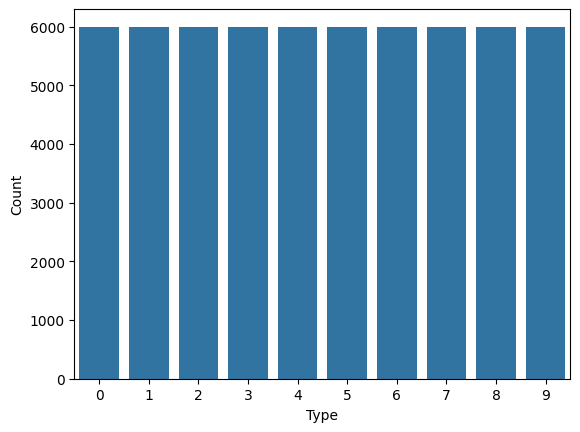

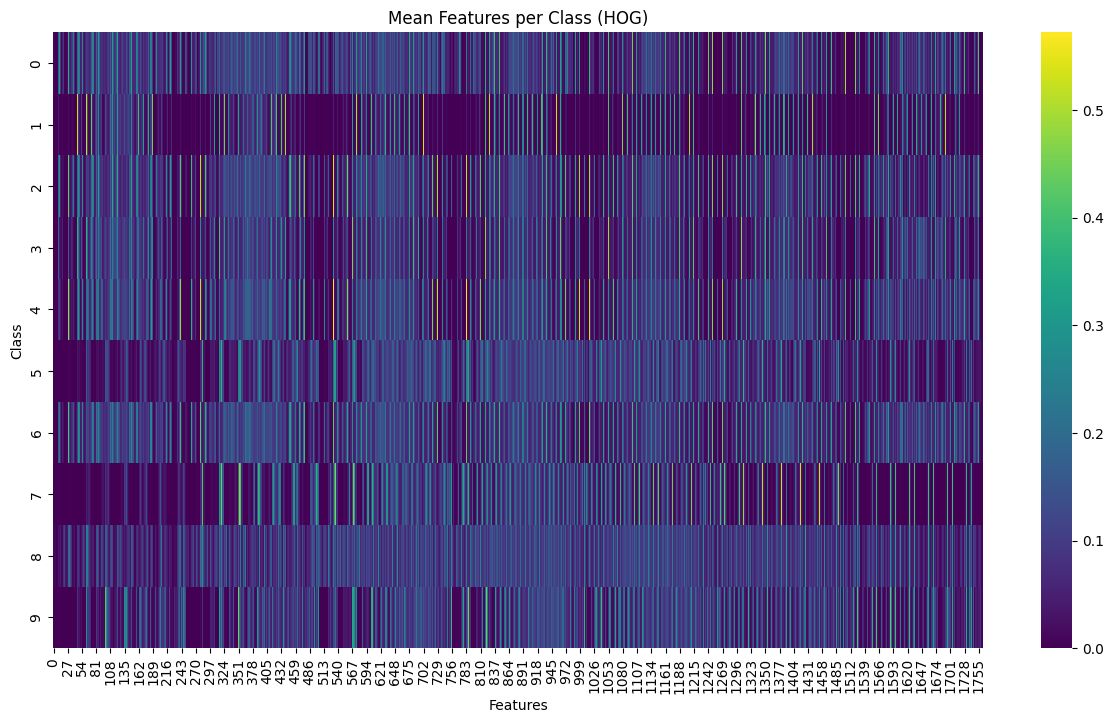

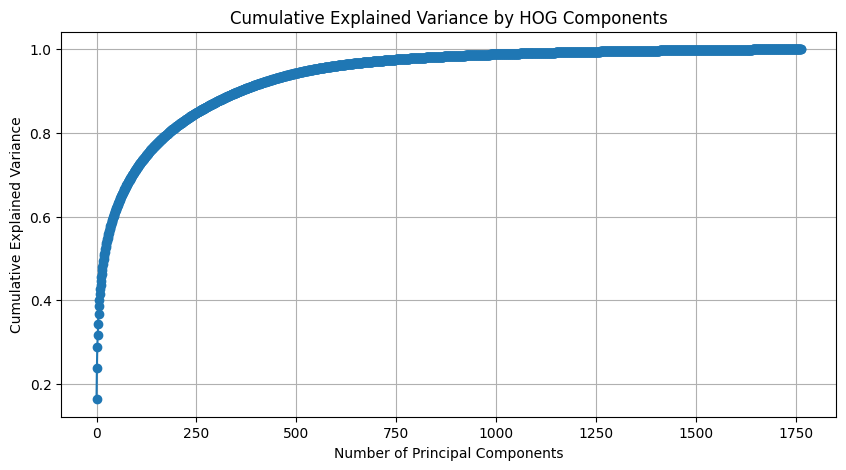

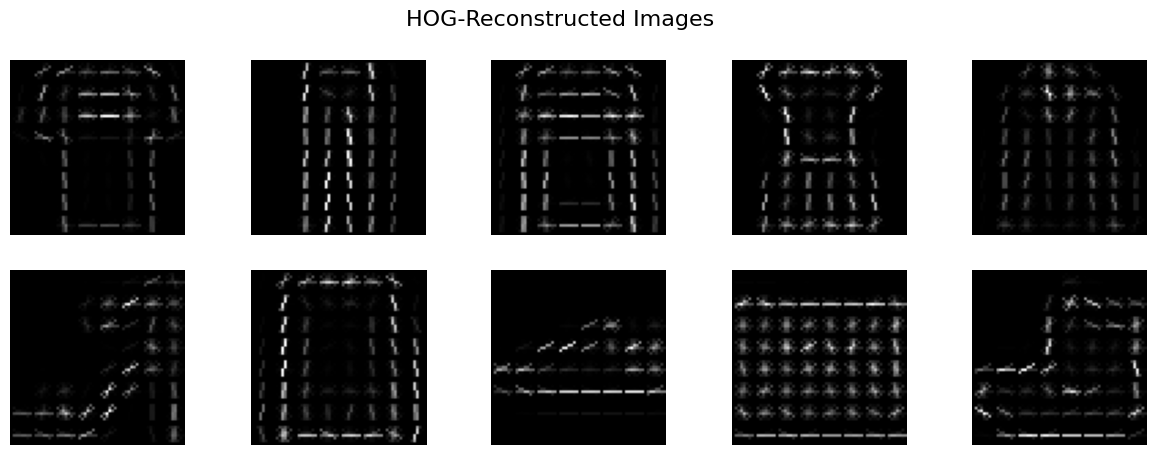

In [12]:
# Train Dataset HOG EDA
fashion_hog_train_dataset = visualise_dataset(f'./features/fashion/hog/dataset.csv', X_train, 'hog')

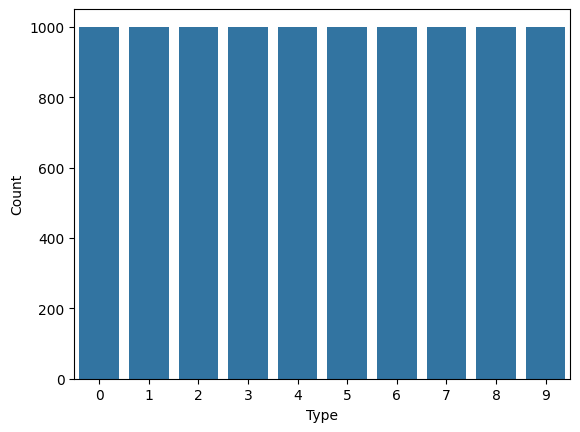

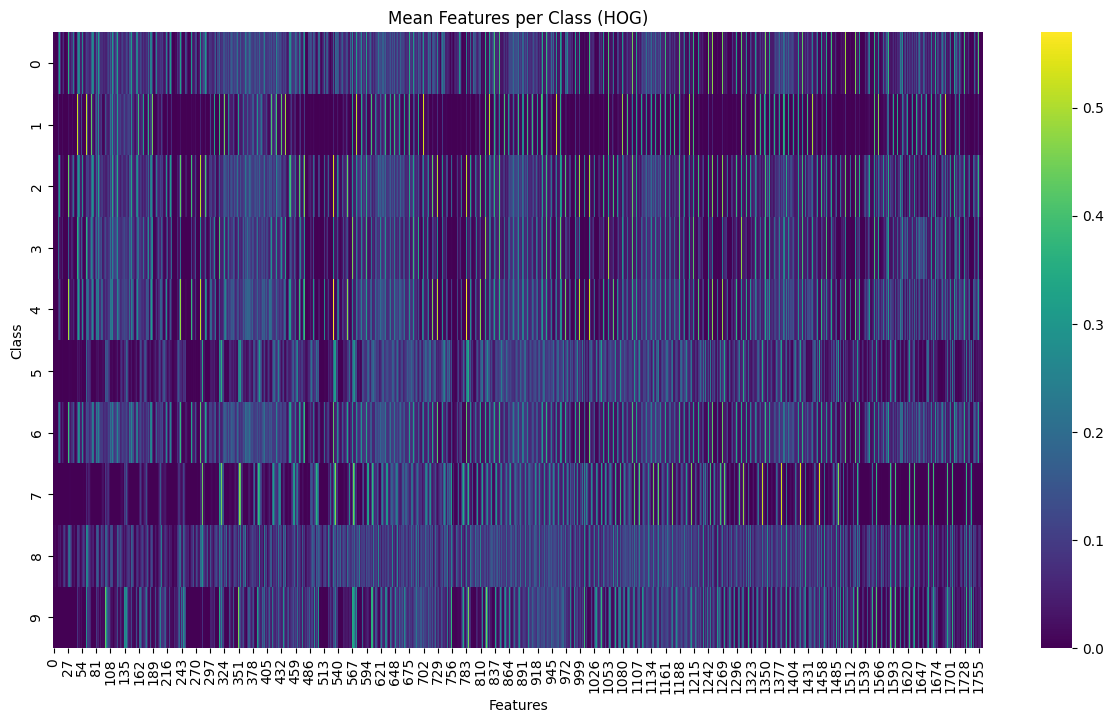

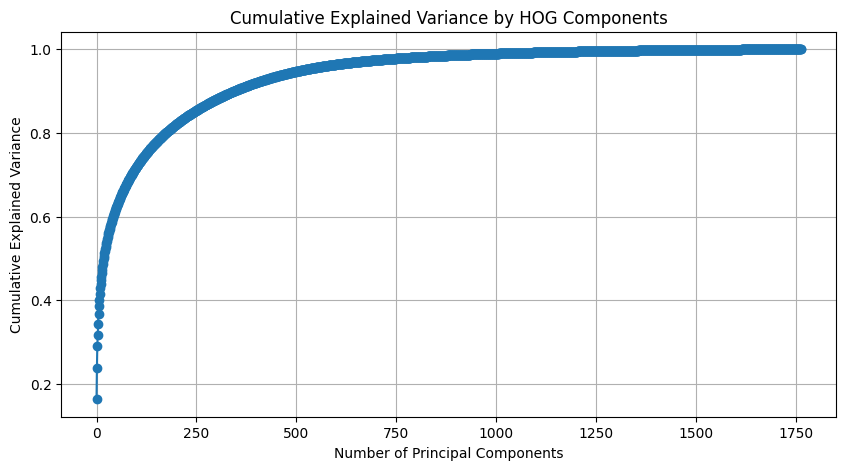

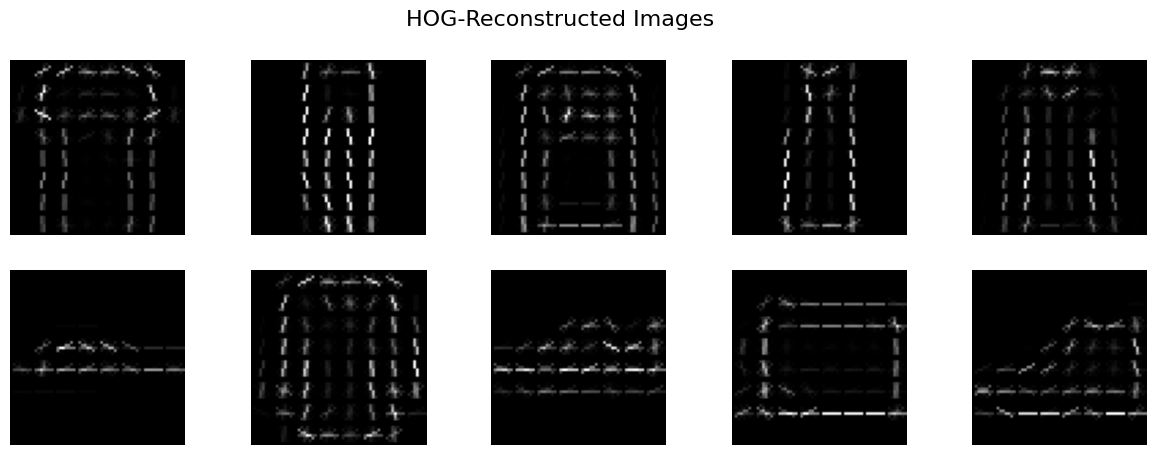

In [13]:
# Test Dataset HOG EDA
fashion_hog_test_dataset = visualise_dataset(f'./features/fashion/hog/test_dataset.csv', X_test, 'hog')

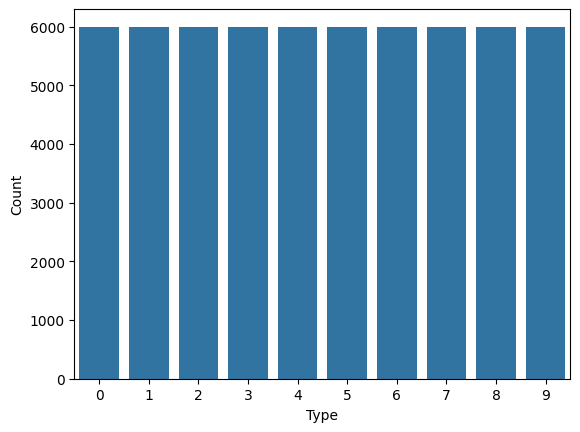

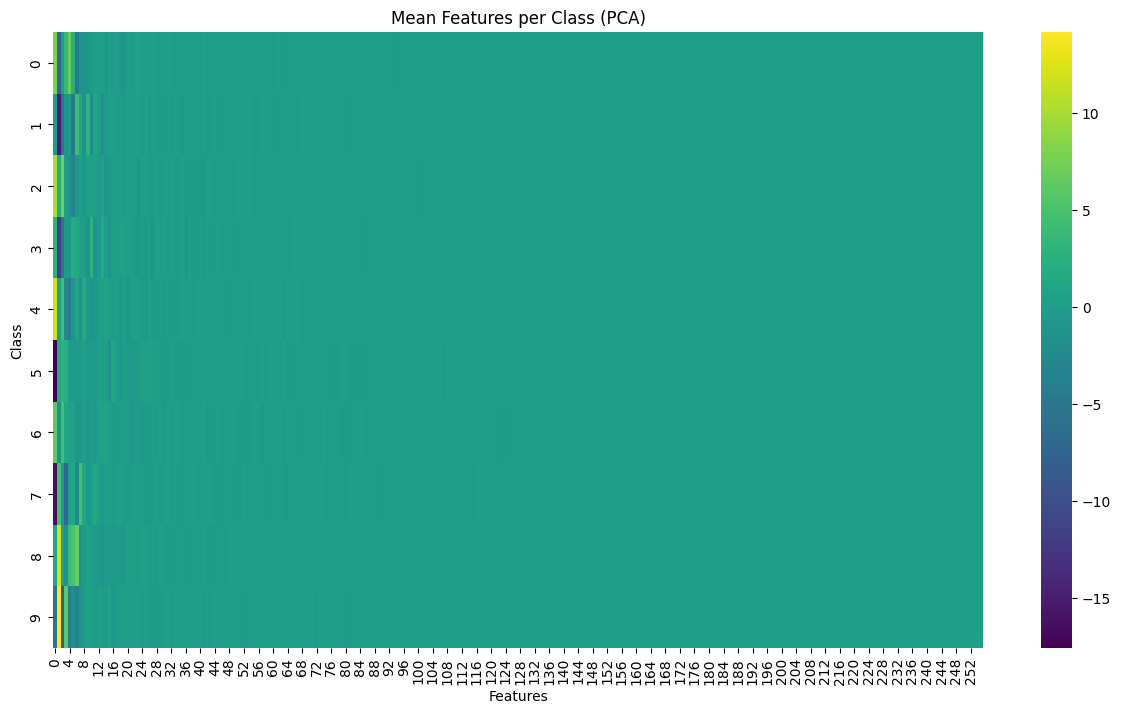

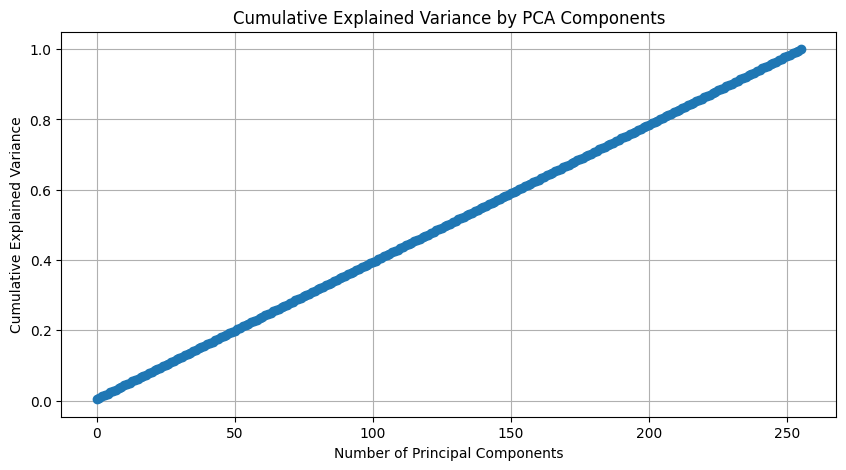

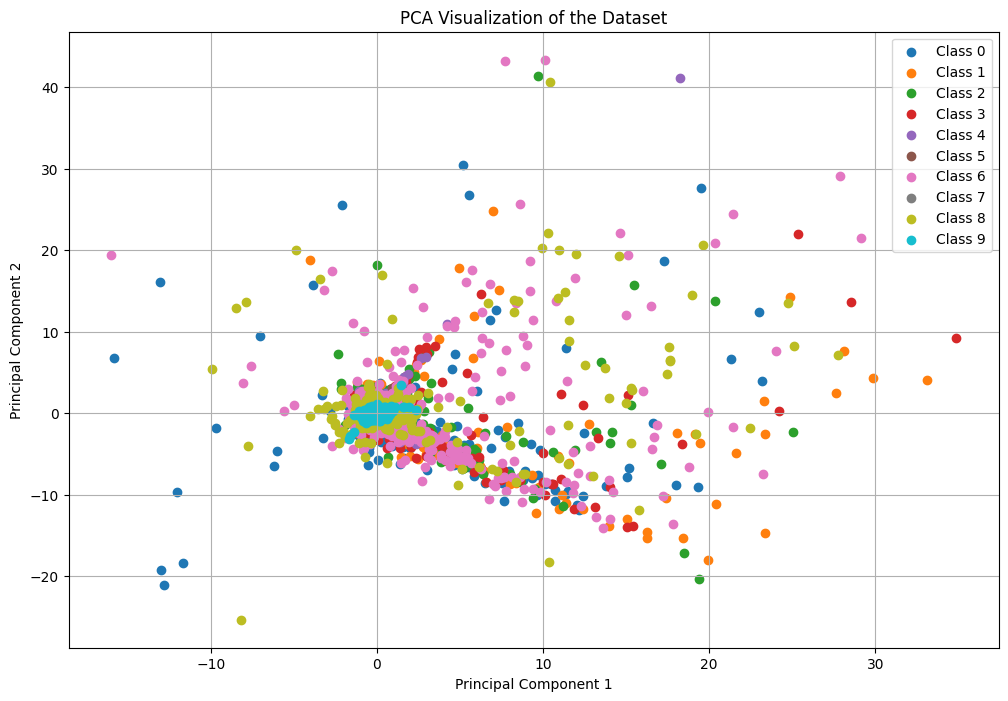

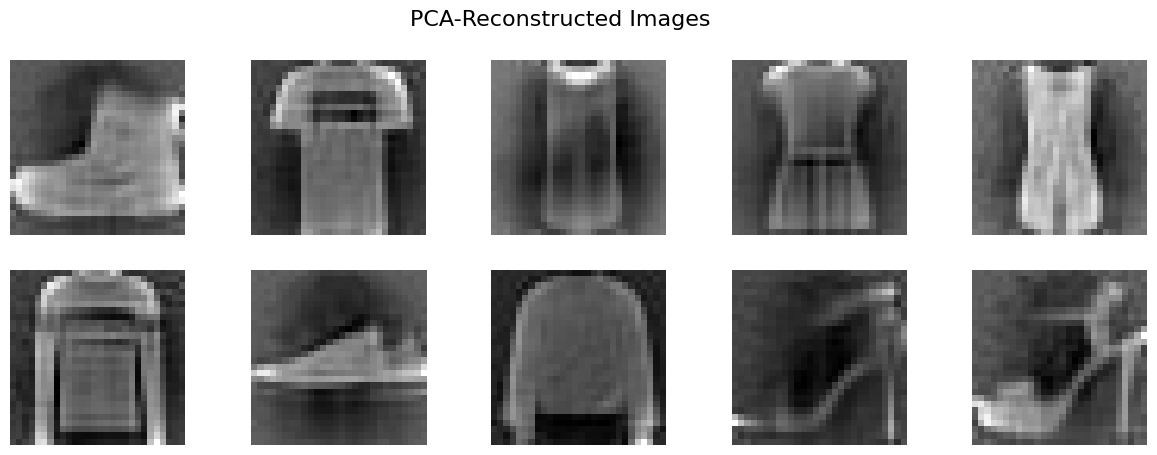

In [13]:
# Train Dataset PCA EDA
fashion_pca_train_dataset = visualise_dataset(f'./features/fashion/pca/dataset.csv', X_train, 'pca')

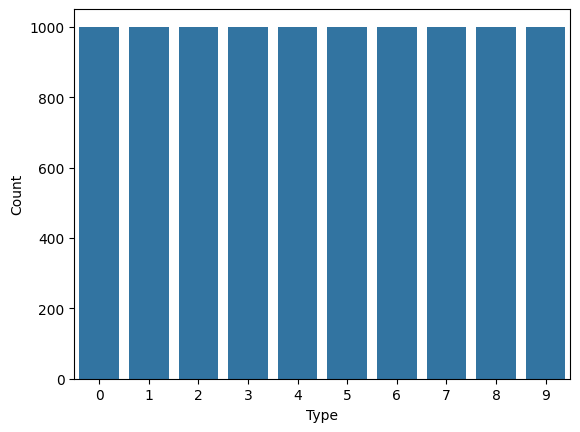

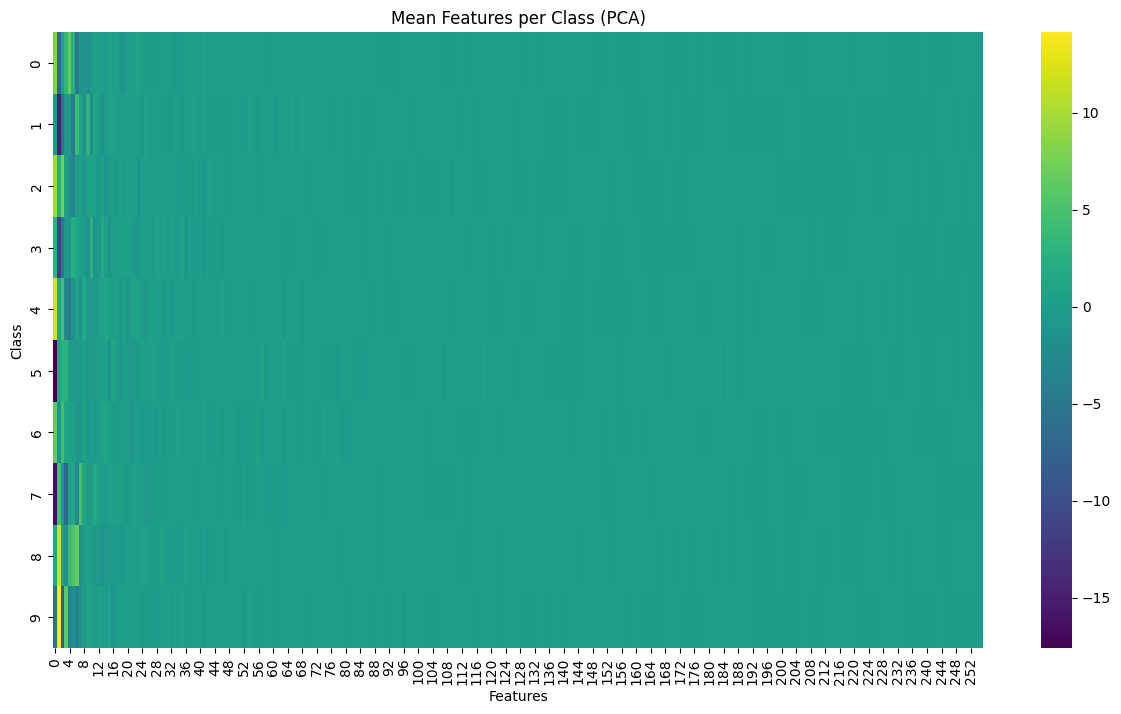

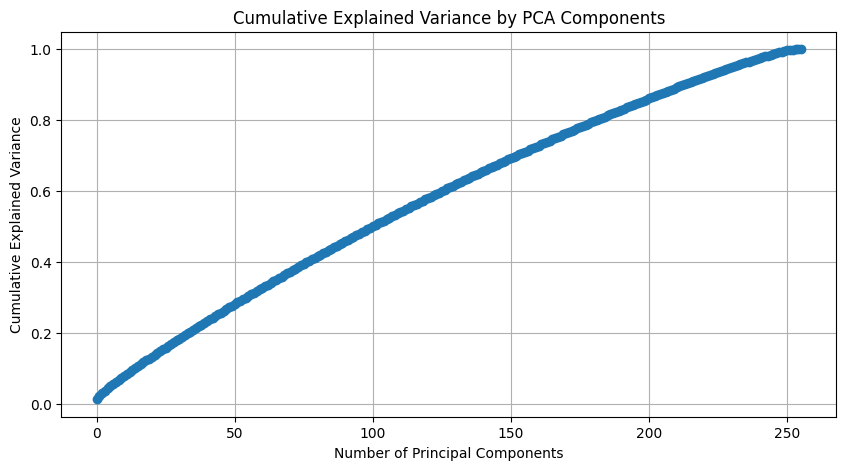

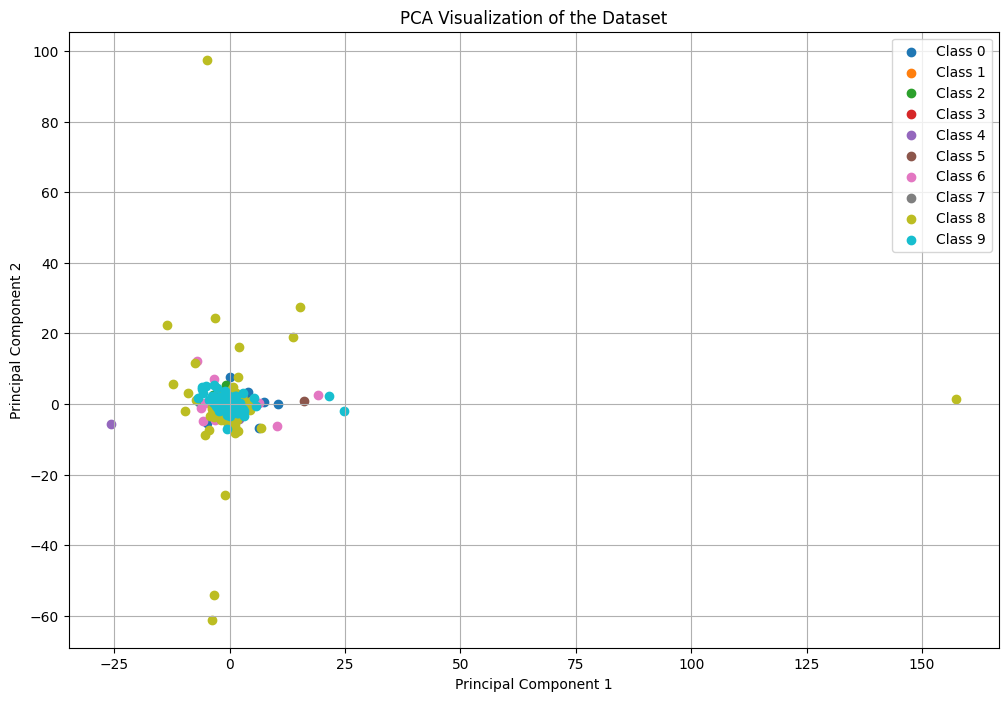

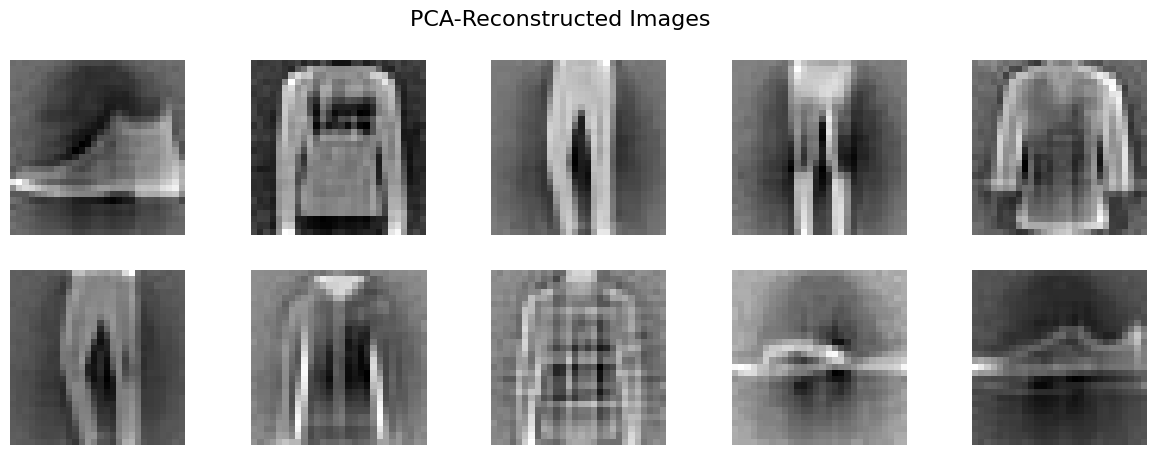

In [14]:
# Test Dataset PCA EDA
fashion_pca_test_dataset = visualise_dataset(f'./features/fashion/pca/test_dataset.csv', X_test, 'pca')

- # Preprocessing

In [ ]:
class DataPreprocessing:
    def __init__(self, dataset, percentile=20):
        self.dataset = dataset
        self.percentile = percentile
        self.selected_features_percentile = None
        self.selector_percentile = None
        self.scaler = None

    def standardize_data(self):
        self.scaler = StandardScaler()
        self.dataset.iloc[:, :-1] = self.scaler.fit_transform(self.dataset.iloc[:, :-1])
        return self

    def fit_select_percentile_features(self):
        X = self.dataset.iloc[:, :-1]
        y = self.dataset.iloc[:, -1]

        self.selector_percentile = SelectPercentile(score_func=f_classif, percentile=self.percentile)
        X_selected = self.selector_percentile.fit_transform(X, y)
        print(X_selected.shape)

        self.dataset = pd.DataFrame(X_selected, index=self.dataset.index)
        self.dataset['label'] = y.reset_index(drop=True)

        print(f"Selected {X_selected.shape[1]} features.")
        return self

    def transform_test_data(self, test_dataset, method='percentile'):
        X_test = test_dataset.iloc[:, :-1]
        y_test = test_dataset.iloc[:, -1]
        selected_features_mask = self.selector_percentile.get_support()

        X_test_scaled = self.scaler.transform(X_test)
        X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=test_dataset.index)
        X_test_selected = X_test_scaled_df.loc[:, selected_features_mask].values

        test_dataset_transformed = pd.DataFrame(X_test_selected, index=test_dataset.index)
        test_dataset_transformed['label'] = y_test.reset_index(drop=True)

        return test_dataset_transformed

    def compare_feature_sets(self):
        print("Original feature set shape:", self.dataset.shape)
        if self.selected_features_percentile is not None:
            print("Reduced set (Select Percentile) shape:", self.selected_features_percentile.shape)

In [15]:
preprocessor = DataPreprocessing(fashion_hog_train_dataset, percentile=20)
preprocessor.standardize_data().fit_select_percentile_features()
fashion_hog_train_dataset = preprocessor.dataset
fashion_hog_test_dataset = preprocessor.transform_test_data(fashion_hog_test_dataset)

(60000, 353)
Selected 353 features using Select Percentile.


- # Models Training

In [17]:
class ModelTrainer:
    def __init__(
        self,
        train_dataset,
        test_dataset,
        estimator,
        parameters_distribution,
        model_name,
        dataset_name,
        validation_size=0.2,
        n_iter=20,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        random_state=42
    ):
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.estimator = estimator
        self.parameters_distribution = parameters_distribution
        self.validation_size = validation_size
        self.n_iter = n_iter
        self.cv = cv
        self.scoring = scoring
        self.n_jobs = n_jobs
        self.random_state = random_state
        self.best_model = None
        self.best_parameters = None
        self.model_name = model_name
        self.dataset_name = dataset_name

        self.X_train = self.train_dataset.iloc[:, :-1]
        self.y_train = self.train_dataset.iloc[:, -1]
        self.X_test = self.test_dataset.iloc[:, :-1]
        self.y_test = self.test_dataset.iloc[:, -1]

    def hyperparameters_tuning(self):
        scoring = {
            'accuracy': 'accuracy',
            'precision': make_scorer(precision_score, average='macro'),
            'recall': make_scorer(recall_score, average='macro'),
            'f1': make_scorer(f1_score, average='macro')
        }

        search = RandomizedSearchCV(
            self.estimator,
            param_distributions=self.parameters_distribution,
            n_iter=self.n_iter,
            scoring=scoring,
            refit='accuracy',
            cv=self.cv,
            n_jobs=self.n_jobs,
            random_state=self.random_state,
            verbose=4,
            return_train_score=True
        )

        search.fit(self.X_train, self.y_train)
        self.best_model = search.best_estimator_
        self.best_parameters = search.best_params_

        self.results_table = pd.DataFrame(search.cv_results_)
        print(f'Best hyperparameters: {self.best_parameters}')
        return self.best_model

    def analyze_results(self):
        metrics_table = self.results_table[
            ['param_' + key for key in self.parameters_distribution.keys()] + 
            ['mean_test_accuracy', 'std_test_accuracy', 'mean_test_precision', 
             'mean_test_recall', 'mean_test_f1']
        ]

        metrics_table.rename(columns={
            'mean_test_accuracy': 'Accuracy (mean)',
            'std_test_accuracy': 'Accuracy (std)',
            'mean_test_precision': 'Precision (mean)',
            'mean_test_recall': 'Recall (mean)',
            'mean_test_f1': 'F1-Score (mean)'
        }, inplace=True)

        metrics_table = metrics_table.round({
            'Accuracy (mean)': 3,
            'Accuracy (std)': 3,
            'Precision (mean)': 3,
            'Recall (mean)': 3,
            'F1-Score (mean)': 3
        })

        metrics_table.to_csv(f'./metrics/{self.dataset_name}/{self.model_name}.csv', index=False)

    def predict(self):
        if self.best_model is not None:
            return self.best_model.predict(self.X_test)
        else:
            return None

    def analysis(self):
        predictions = self.predict()
        if predictions is not None:
            print(f'Best hyperparameters selected:\n{self.best_parameters}')
            accuracy = accuracy_score(self.y_test, predictions)
            f1score = f1_score(self.y_test, predictions, average='micro')
            recall = recall_score(self.y_test, predictions, average='micro')
            print(f'\nAccuracy: {accuracy:.4f}')
            print(f'F1-score: {f1score:.4f}')
            print(f'Recall: {recall:.4f}')

            print(f'\nClassification Report:\n{classification_report(self.y_test, predictions)}\n')

            print('Confusion Matrix:')
            cm = confusion_matrix(self.y_test, predictions)
            conf_matrix = ConfusionMatrixDisplay(confusion_matrix=cm)
            conf_matrix.plot()
            plt.show()
        else:
            print('Training not done!')

    def results(self):
        self.hyperparameters_tuning()
        self.analyze_results()
        self.analysis()

- Logistic Regression

Fitting 3 folds for each of 20 candidates, totalling 60 fits


C:\Users\Bogdan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Bogdan\AppData\Local\Temp\ipykernel_14196\124588716.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_table.rename(columns={


Best hyperparameters: {'multi_class': 'multinomial', 'C': 60}
Best hyperparameters selected:
{'multi_class': 'multinomial', 'C': 60}

Accuracy: 0.8703
F1-score: 0.8703
Recall: 0.8703

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.83      1000
           1       0.96      0.96      0.96      1000
           2       0.81      0.82      0.81      1000
           3       0.87      0.86      0.87      1000
           4       0.76      0.80      0.78      1000
           5       0.96      0.96      0.96      1000
           6       0.68      0.63      0.66      1000
           7       0.92      0.93      0.92      1000
           8       0.97      0.97      0.97      1000
           9       0.95      0.94      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000


Confusion Matrix:


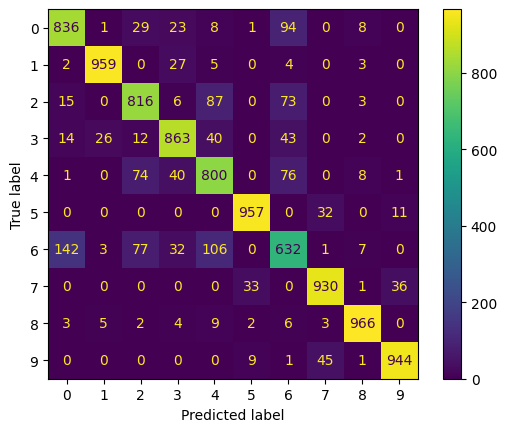

In [18]:
ModelTrainer(
    train_dataset=fashion_hog_train_dataset,
    test_dataset=fashion_hog_test_dataset,
    estimator=LogisticRegression(max_iter=100, random_state=42),
    parameters_distribution={'C': [10 * x for x in range(1, 11)], 'multi_class': ['ovr', 'multinomial']},
    model_name='logistic_regression',
    dataset_name='fashion',
    cv=3
).results()

- SVM

C:\Users\Bogdan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 10 is smaller than n_iter=20. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best hyperparameters: {'kernel': 'rbf', 'C': 10}


C:\Users\Bogdan\AppData\Local\Temp\ipykernel_4536\3624232938.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_table.rename(columns={


Best hyperparameters selected:
{'kernel': 'rbf', 'C': 10}

Accuracy: 0.8862
F1-score: 0.8862
Recall: 0.8862

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84      1000
           1       0.98      0.97      0.98      1000
           2       0.83      0.84      0.83      1000
           3       0.89      0.89      0.89      1000
           4       0.81      0.82      0.82      1000
           5       0.96      0.95      0.95      1000
           6       0.72      0.69      0.70      1000
           7       0.92      0.94      0.93      1000
           8       0.97      0.97      0.97      1000
           9       0.96      0.94      0.95      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000


Confusion Matrix:


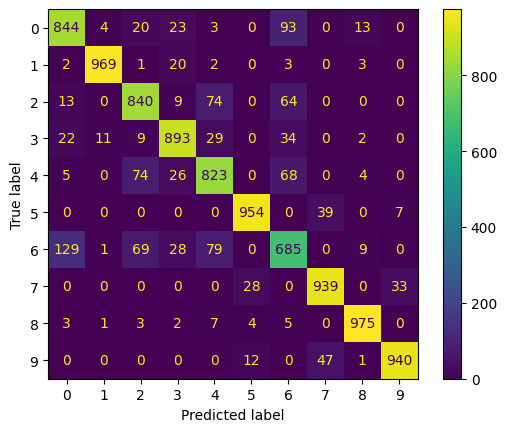

In [25]:
ModelTrainer(
    train_dataset=fashion_hog_train_dataset,
    test_dataset=fashion_hog_test_dataset,
    estimator=SVC(random_state=42),
    parameters_distribution={'C': [10, 20, 30, 40, 50], 'kernel': ['rbf', 'poly']},
    model_name='svm',
    dataset_name='fashion',
    cv=3
).results()

- Random Forest

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best hyperparameters: {'n_estimators': 200, 'max_samples': 0.7, 'max_depth': 50}


C:\Users\Bogdan\AppData\Local\Temp\ipykernel_14196\124588716.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_table.rename(columns={


Best hyperparameters selected:
{'n_estimators': 200, 'max_samples': 0.7, 'max_depth': 50}

Accuracy: 0.8758
F1-score: 0.8758
Recall: 0.8758

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1000
           1       0.99      0.95      0.97      1000
           2       0.82      0.83      0.83      1000
           3       0.85      0.89      0.87      1000
           4       0.79      0.80      0.80      1000
           5       0.95      0.95      0.95      1000
           6       0.69      0.64      0.67      1000
           7       0.92      0.93      0.92      1000
           8       0.94      0.97      0.96      1000
           9       0.95      0.94      0.94      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000


Confusion Matrix:


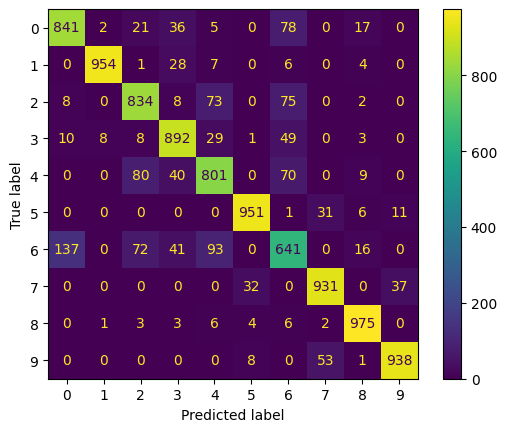

In [19]:
ModelTrainer(
    fashion_hog_train_dataset,
    fashion_hog_test_dataset,
    RandomForestClassifier(random_state=42),
    parameters_distribution={
        'n_estimators': [100, 150, 200],
        'max_depth': [50, 100, 150],
        'max_samples': [0.5, 0.6, 0.7],
    },
    model_name='random_forest',
    dataset_name='fashion',
    cv=3
).results()

- Gradient Boosting Trees

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best hyperparameters: {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1}
Best hyperparameters selected:
{'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1}

Accuracy: 0.8719
F1-score: 0.8719
Recall: 0.8719

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1000
           1       0.98      0.96      0.97      1000
           2       0.83      0.81      0.82      1000
           3       0.87      0.86      0.87      1000
           4       0.78      0.80      0.79      1000
           5       0.94      0.94      0.94      1000
           6       0.68      0.67      0.68      1000
           7       0.91      0.93      0.92      1000
           8       0.95      0.97      0.96      1000
           9       0.95      0.94      0.94      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.8

C:\Users\Bogdan\AppData\Local\Temp\ipykernel_19272\124588716.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_table.rename(columns={


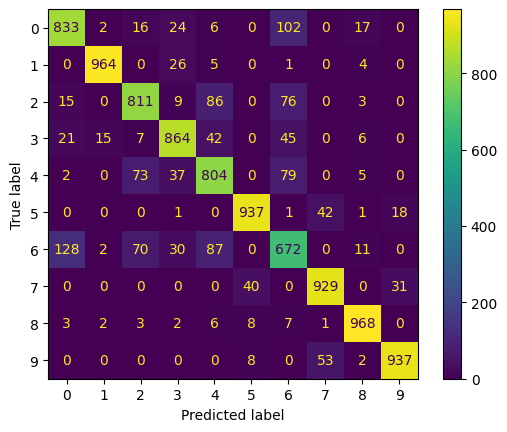

In [23]:
ModelTrainer(
    fashion_hog_train_dataset,
    fashion_hog_test_dataset,
    XGBClassifier(random_state=42, eval_metric='logloss'),
    parameters_distribution={
        'n_estimators': [50, 100, 150],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
    },
    model_name='xgb',
    dataset_name='fashion',
    cv=3
).results()

# FRUITS-360

In [25]:
loader_fashion = DatasetLoader(dataset_name='fruits', data_path=data_path, kind='train', archive_path='./archive.zip')
X_train, y_train = loader_fashion.load()
loader_fashion = DatasetLoader(dataset_name='fruits', data_path=data_path, kind='t10k', archive_path='./archive.zip')
X_test, y_test = loader_fashion.load()

Unique labels: {'Nut Forest', 'Plum', 'Apricot', 'Cantaloupe', 'Pear Williams', 'Carrot', 'Melon Piel de Sapo', 'Pear Forelle', 'Banana Lady Finger', 'Nectarine Flat', 'Hazelnut', 'Grape Blue', 'Kiwi', 'Nectarine', 'Pepino', 'Pineapple', 'Strawberry', 'Banana Red', 'Lemon', 'Pear Kaiser', 'Apple Red Yellow', 'Watermelon', 'Apple', 'Clementine', 'Maracuja', 'Onion Red Peeled', 'Zucchini dark', 'Dates', 'Kumquats', 'Kaki', 'Quince', 'Papaya', 'Tamarillo', 'Huckleberry', 'Cucumber Ripe', 'Limes', 'Onion White', 'Granadilla', 'Pepper Yellow', 'Potato White', 'Cherry Wax Red', 'Cactus fruit', 'Cucumber', 'Tomato Yellow', 'Pear Abate', 'Mulberry', 'Corn', 'Eggplant long', 'Pear Stone', 'Apple Pink Lady', 'Chestnut', 'Pepper Green', 'Pineapple Mini', 'Peach', 'Eggplant', 'Pepper Orange', 'Apple Golden', 'Tomato Cherry Red', 'Apple Crimson Snow', 'Pear Monster', 'Cauliflower', 'Corn Husk', 'Pepper Red', 'Potato Red Washed', 'Tomato Maroon', 'Mango Red', 'Grape White', 'Peach Flat', 'Potato Red

In [ ]:
get_statistics('fruits', 'hog', data_path, './archive.zip')
get_statistics('fruits', 'orb', data_path, './archive.zip')

Unique labels: {'Nut Forest', 'Plum', 'Apricot', 'Cantaloupe', 'Pear Williams', 'Carrot', 'Melon Piel de Sapo', 'Pear Forelle', 'Banana Lady Finger', 'Nectarine Flat', 'Hazelnut', 'Grape Blue', 'Kiwi', 'Nectarine', 'Pepino', 'Pineapple', 'Strawberry', 'Banana Red', 'Lemon', 'Pear Kaiser', 'Apple Red Yellow', 'Watermelon', 'Apple', 'Clementine', 'Maracuja', 'Onion Red Peeled', 'Zucchini dark', 'Dates', 'Kumquats', 'Kaki', 'Quince', 'Papaya', 'Tamarillo', 'Huckleberry', 'Cucumber Ripe', 'Limes', 'Onion White', 'Granadilla', 'Pepper Yellow', 'Potato White', 'Cherry Wax Red', 'Cactus fruit', 'Cucumber', 'Tomato Yellow', 'Pear Abate', 'Mulberry', 'Corn', 'Eggplant long', 'Pear Stone', 'Apple Pink Lady', 'Chestnut', 'Pepper Green', 'Pineapple Mini', 'Peach', 'Eggplant', 'Pepper Orange', 'Apple Golden', 'Tomato Cherry Red', 'Apple Crimson Snow', 'Pear Monster', 'Cauliflower', 'Corn Husk', 'Pepper Red', 'Potato Red Washed', 'Tomato Maroon', 'Mango Red', 'Grape White', 'Peach Flat', 'Potato Red

- # EDA

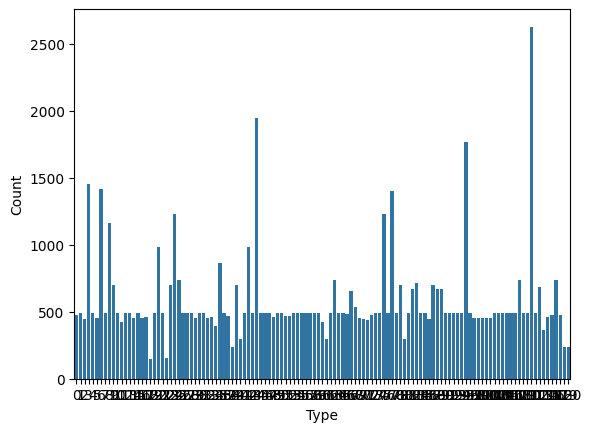

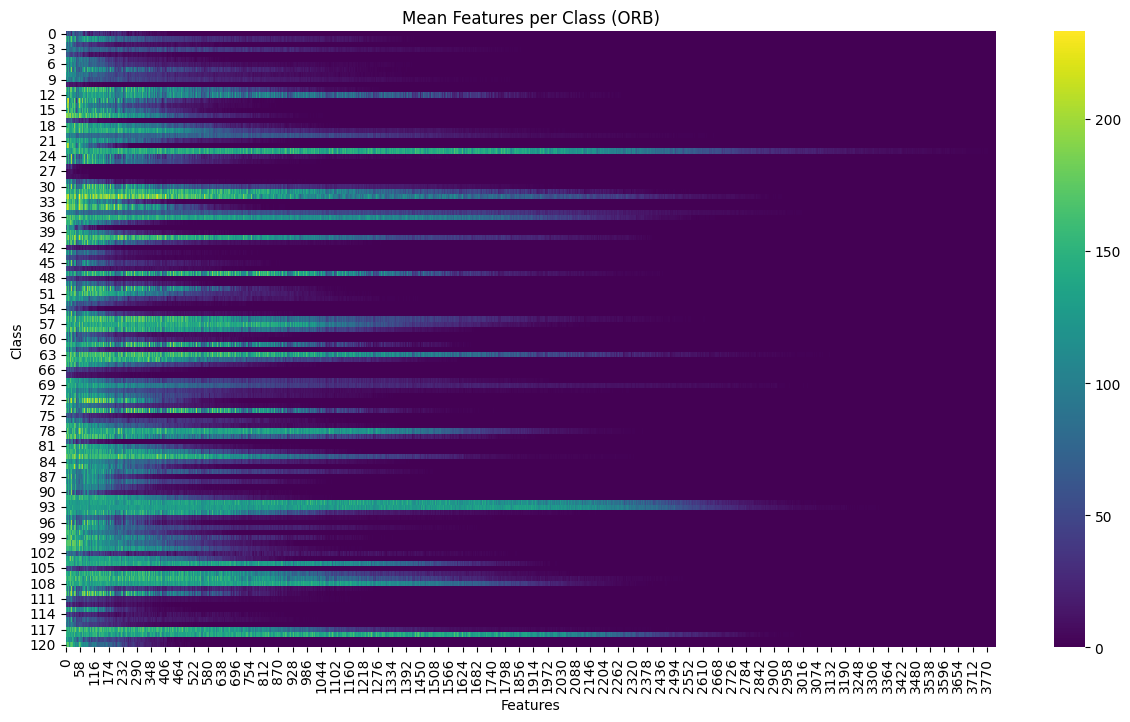

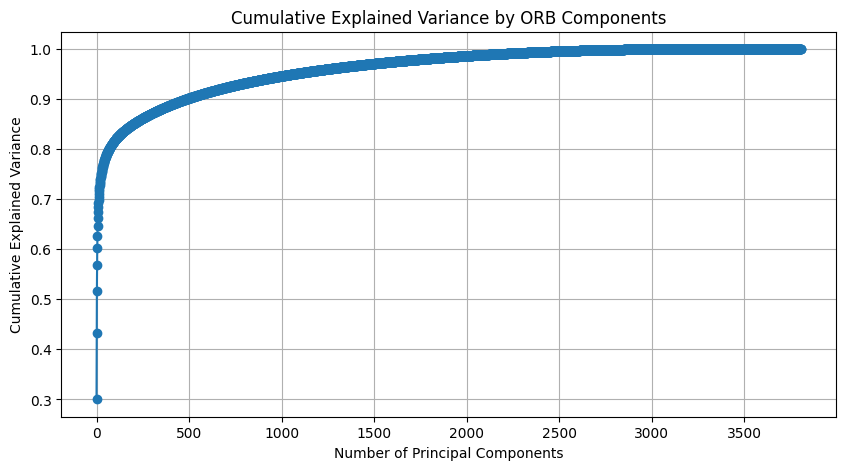

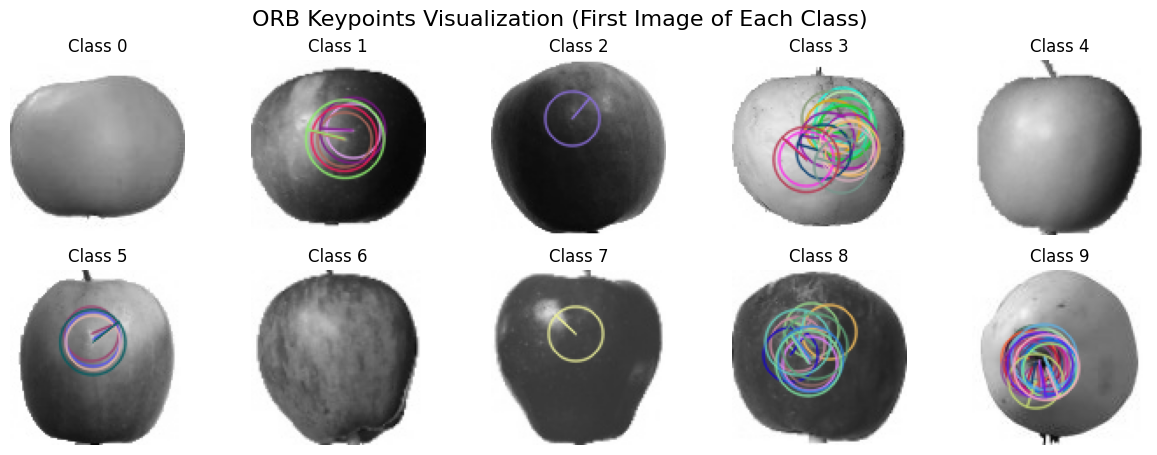

In [29]:
# Train Dataset ORB EDA
fruits_orb_train_dataset = visualise_dataset(f'./features/fruits/orb/dataset.csv', X_train, 'orb')

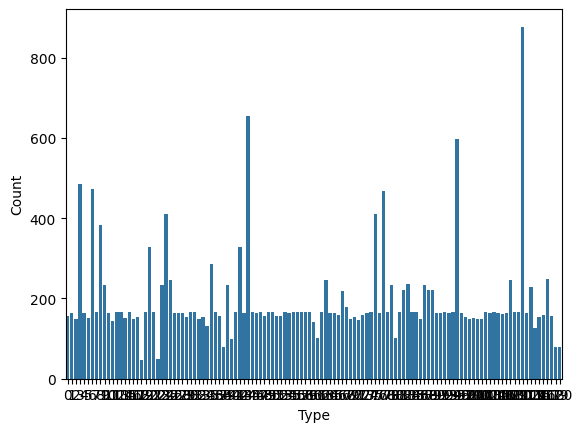

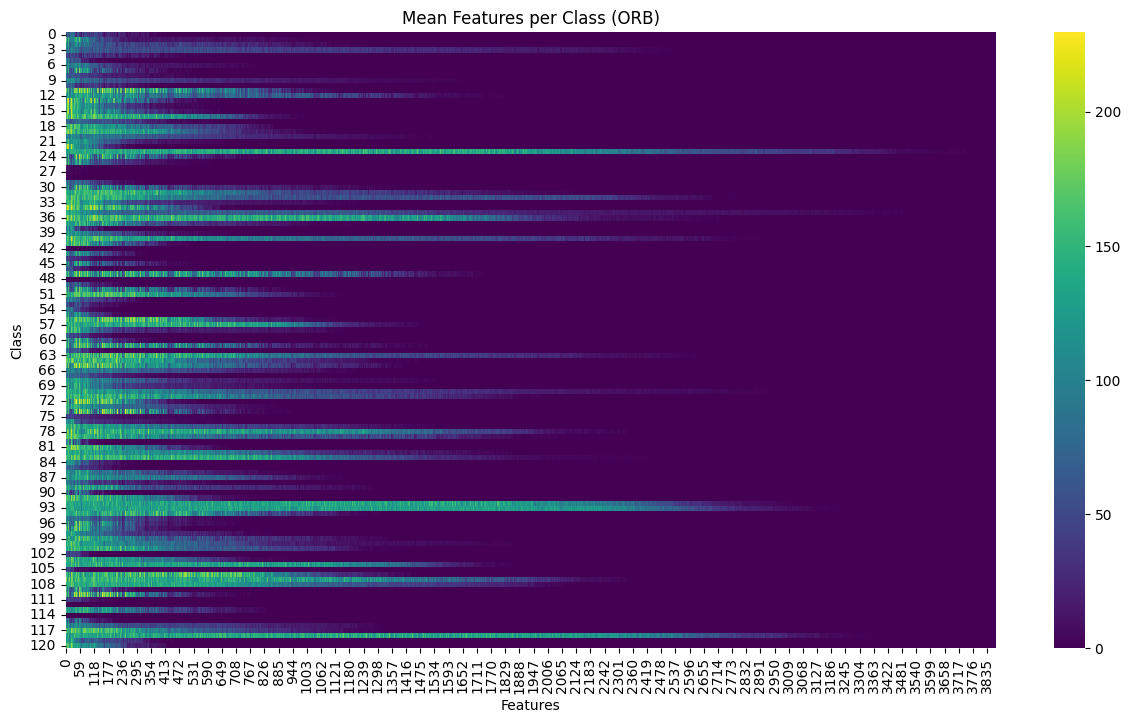

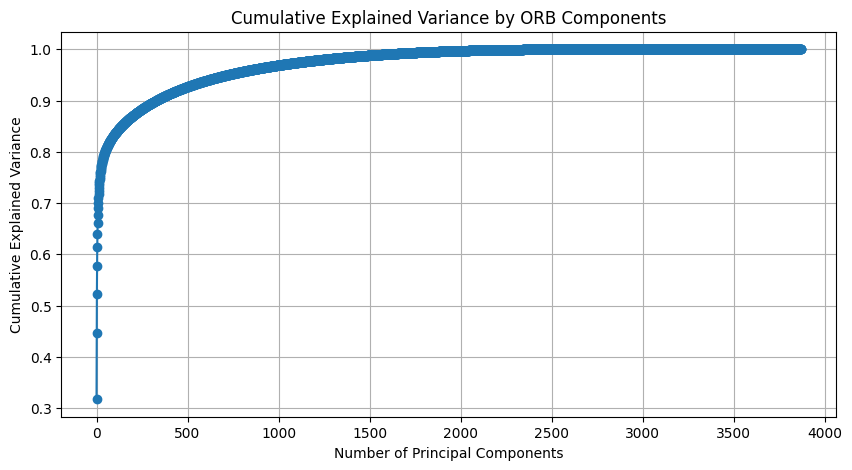

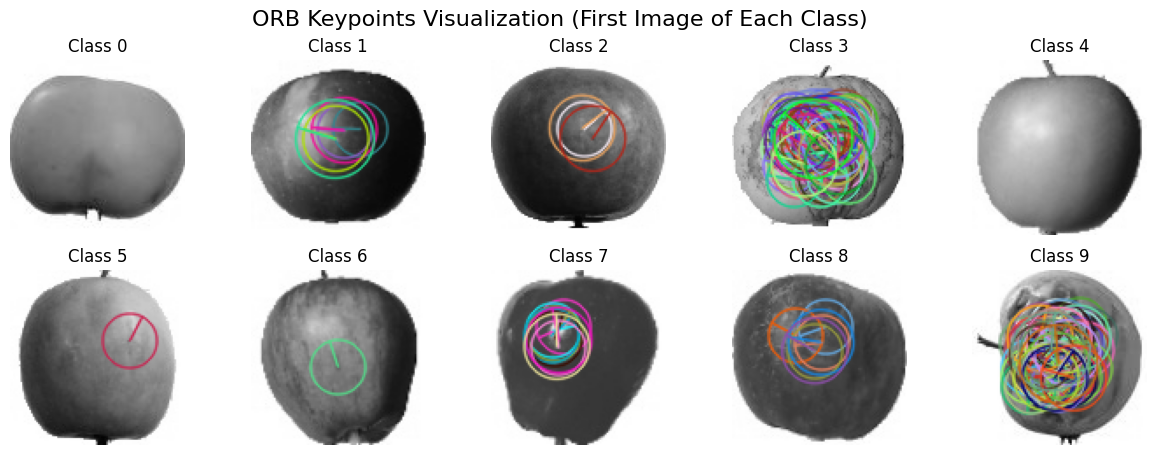

In [30]:
# Test Dataset ORB EDA
fruits_orb_test_dataset = visualise_dataset(f'./features/fruits/orb/test_dataset.csv', X_test, 'orb')

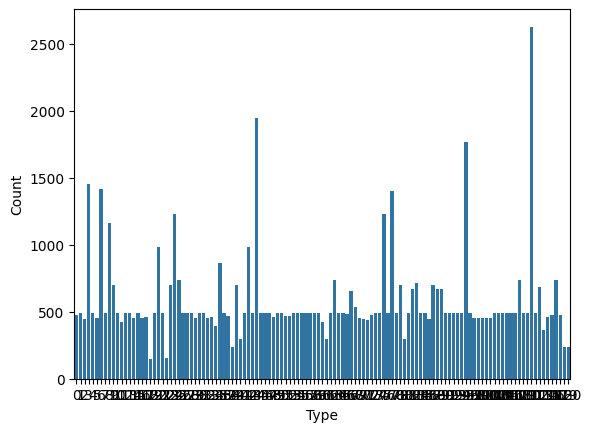

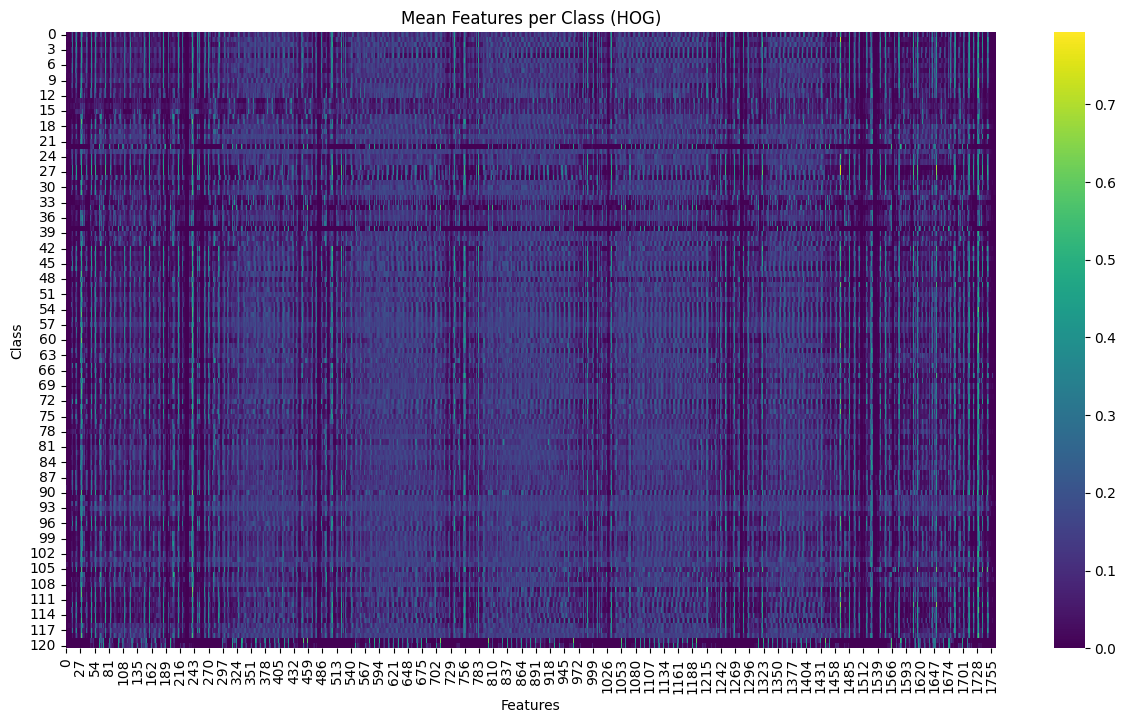

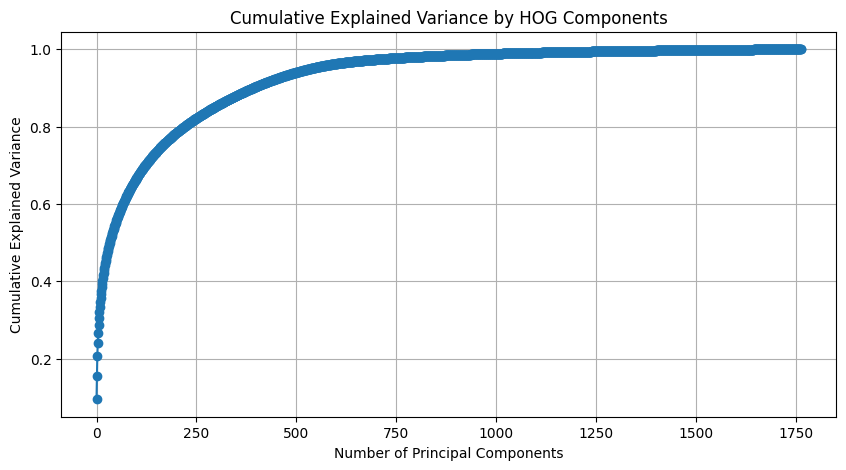

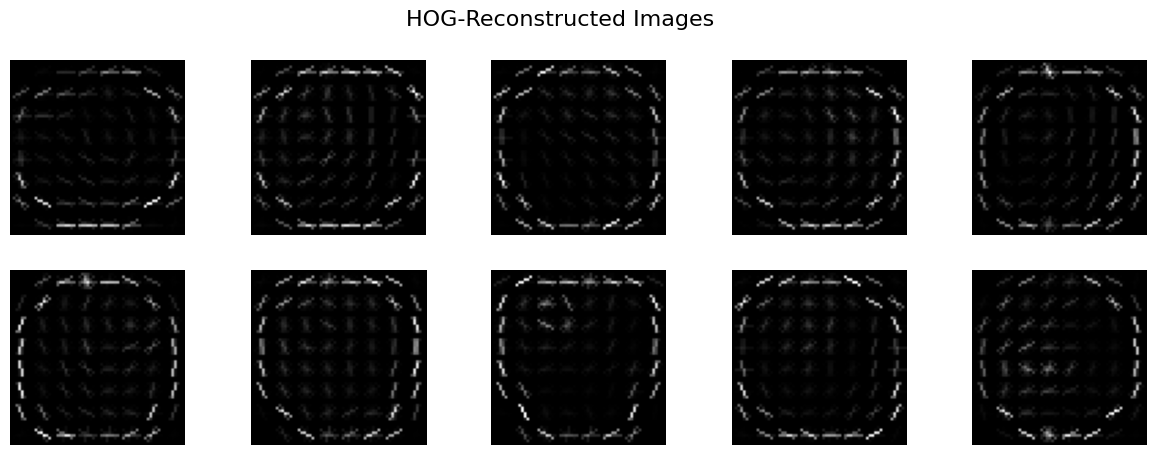

In [19]:
# Train Dataset HOG EDA
fruits_hog_train_dataset = visualise_dataset(f'./features/fruits/hog/dataset.csv', X_train, 'hog')

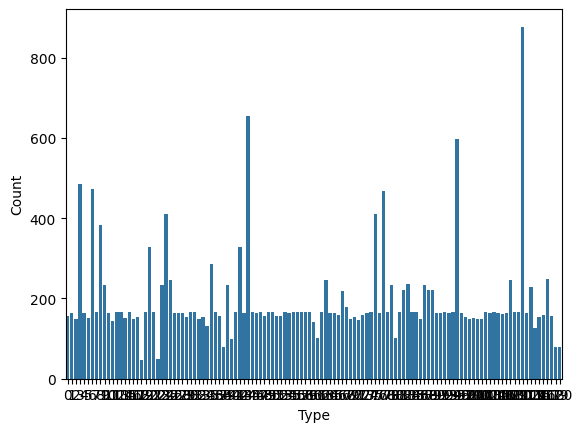

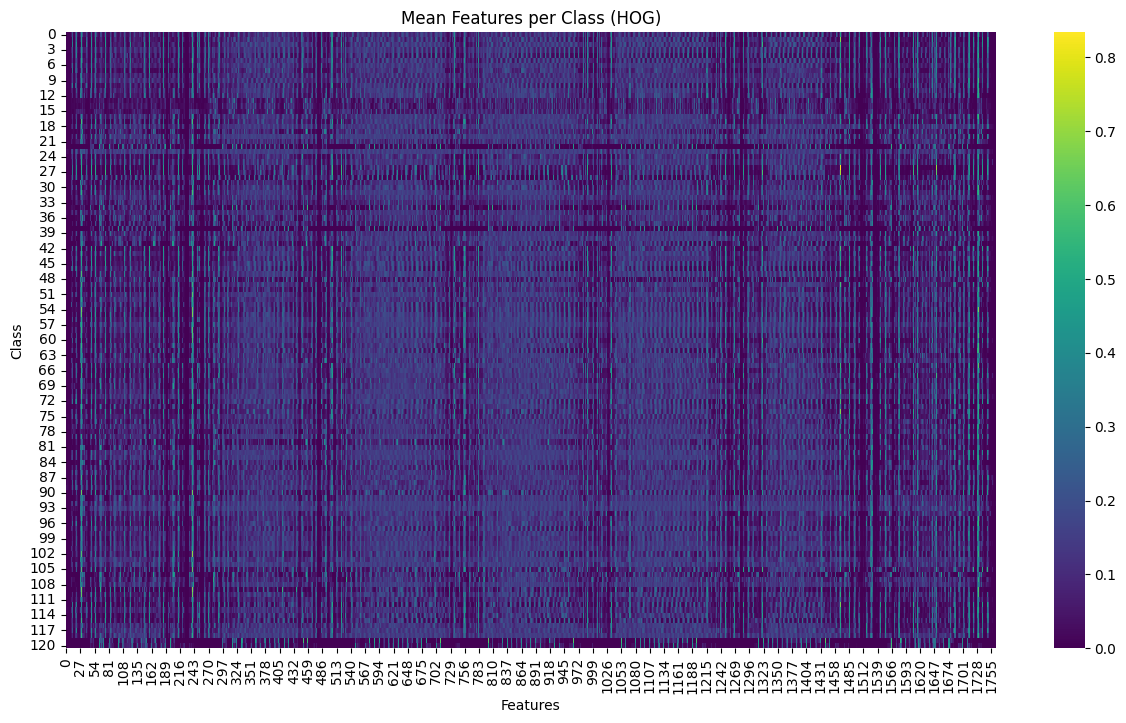

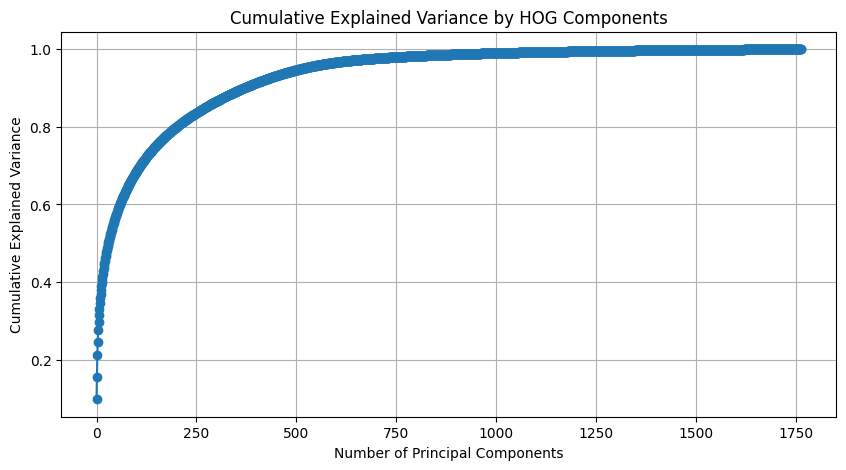

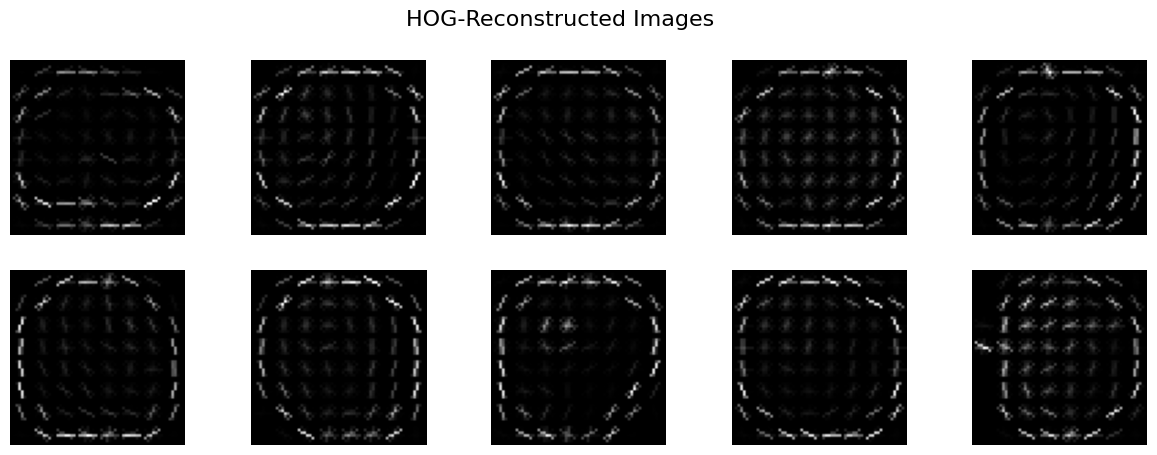

In [20]:
# Test Dataset HOG EDA
fruits_hog_test_dataset = visualise_dataset(f'./features/fruits/hog/test_dataset.csv', X_test, 'hog')

- # Preprocessing

In [ ]:
preprocessor = DataPreprocessing(fruits_hog_train_dataset, percentile=10)
preprocessor.standardize_data().fit_select_percentile_features()
fruits_hog_train_dataset = preprocessor.dataset
fruits_hog_test_dataset = preprocessor.transform_test_data(fruits_hog_test_dataset)

(70491, 353)
Selected 353 features using Select Percentile.


- # Training

- Logistic Regression

C:\Users\Bogdan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 10 is smaller than n_iter=20. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best hyperparameters: {'multi_class': 'multinomial', 'C': 50}
Best hyperparameters selected:
{'multi_class': 'multinomial', 'C': 50}

Accuracy: 0.7451
F1-score: 0.7451
Recall: 0.7451

Classification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       157
           1       0.67      0.64      0.66       164
           2       0.78      0.68      0.72       148
           3       0.81      0.76      0.78       485
           4       0.75      0.70      0.72       164
           5       0.80      0.80      0.80       152
           6       0.62      0.61      0.61       472
           7       0.69      0.84      0.76       166
           8       0.57      0.62      0.59       383
           9       0.80      1.00      0.89       234
          10       0.70      0.84      0.76       164
          11       0.65      0.60      0.62       143
          12       0.88      

C:\Users\Bogdan\AppData\Local\Temp\ipykernel_11640\124588716.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_table.rename(columns={


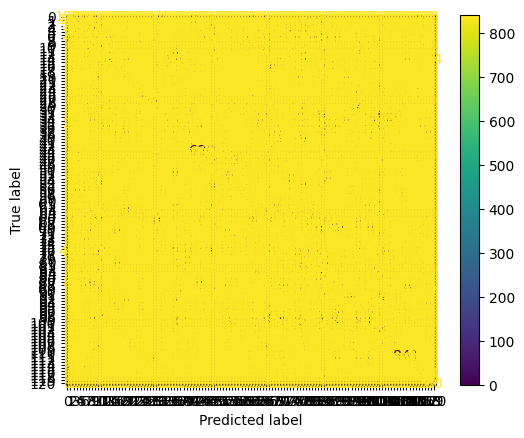

In [23]:
ModelTrainer(
    train_dataset=fruits_hog_train_dataset,
    test_dataset=fruits_hog_test_dataset,
    estimator=LogisticRegression(max_iter=100, random_state=42),
    parameters_distribution={'C': [10, 20, 30, 40, 50], 'multi_class': ['ovr', 'multinomial']},
    model_name='logistic_regression',
    dataset_name='fruits',
    cv=3
).results()

- SVM

C:\Users\Bogdan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 4 is smaller than n_iter=20. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best hyperparameters: {'kernel': 'rbf', 'C': 1}


C:\Users\Bogdan\AppData\Local\Temp\ipykernel_19272\124588716.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_table.rename(columns={


Best hyperparameters selected:
{'kernel': 'rbf', 'C': 1}

Accuracy: 0.8186
F1-score: 0.8186
Recall: 0.8186

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       157
           1       0.84      0.68      0.75       164
           2       0.55      0.80      0.65       148
           3       0.81      0.88      0.85       485
           4       0.85      0.70      0.77       164
           5       0.65      0.78      0.71       152
           6       0.61      0.85      0.71       472
           7       0.97      0.98      0.98       166
           8       0.72      0.87      0.79       383
           9       0.90      1.00      0.95       234
          10       0.98      0.80      0.88       164
          11       0.69      0.72      0.71       143
          12       0.84      0.93      0.88       166
          13       0.65      0.67      0.66       166
          14       0.54      0.50      0.52       152
    

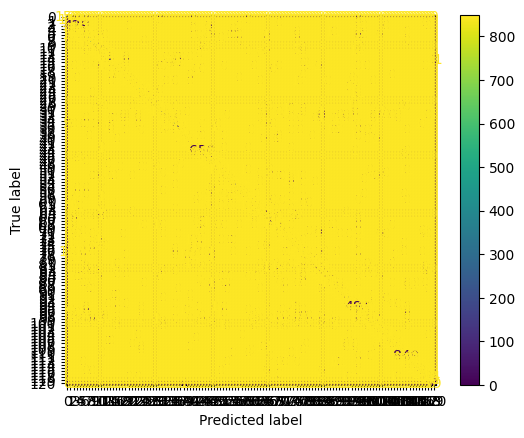

In [32]:
ModelTrainer(
    train_dataset=fruits_hog_train_dataset,
    test_dataset=fruits_hog_test_dataset,
    estimator=SVC(random_state=42),
    parameters_distribution={'C': [0.1, 1], 'kernel': ['rbf', 'poly']},
    model_name='svm',
    dataset_name='fruits',
    cv=3
).results()

- Random Forest

C:\Users\Bogdan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best hyperparameters: {'n_estimators': 100, 'max_samples': 0.6, 'max_depth': 100}


C:\Users\Bogdan\AppData\Local\Temp\ipykernel_2408\124588716.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_table.rename(columns={


Best hyperparameters selected:
{'n_estimators': 100, 'max_samples': 0.6, 'max_depth': 100}

Accuracy: 0.7732
F1-score: 0.7732
Recall: 0.7732

Classification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       157
           1       0.80      0.65      0.72       164
           2       0.67      0.74      0.71       148
           3       0.71      0.87      0.79       485
           4       0.92      0.67      0.77       164
           5       0.60      0.66      0.63       152
           6       0.55      0.85      0.67       472
           7       0.95      0.97      0.96       166
           8       0.80      0.68      0.74       383
           9       0.86      1.00      0.93       234
          10       0.84      0.77      0.80       164
          11       0.67      0.66      0.66       143
          12       0.72      0.90      0.80       166
          13       0.69      0.63      0.66       166
          14       0.70 

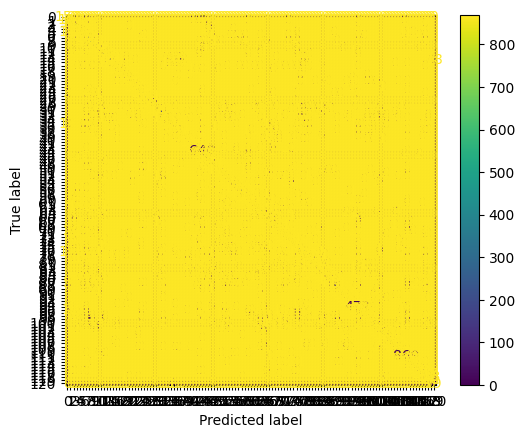

In [38]:
ModelTrainer(
    train_dataset=fruits_hog_train_dataset,
    test_dataset=fruits_hog_test_dataset,
    estimator=RandomForestClassifier(random_state=42),
    parameters_distribution={
        'n_estimators': [50, 100],
        'max_depth': [50, 100],
        'max_samples': [0.6, 0.7],
    },
    model_name='random_forest',
    dataset_name='fruits',
    cv=3
).results()

- Gradient Boosting Trees

C:\Users\Bogdan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best hyperparameters: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1}


C:\Users\Bogdan\AppData\Local\Temp\ipykernel_2408\124588716.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_table.rename(columns={


Best hyperparameters selected:
{'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1}

Accuracy: 0.7465
F1-score: 0.7465
Recall: 0.7465

Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       157
           1       0.83      0.65      0.73       164
           2       0.61      0.60      0.61       148
           3       0.79      0.81      0.80       485
           4       0.84      0.66      0.74       164
           5       0.64      0.78      0.70       152
           6       0.61      0.82      0.70       472
           7       0.87      0.90      0.88       166
           8       0.72      0.68      0.70       383
           9       0.85      1.00      0.92       234
          10       0.77      0.73      0.75       164
          11       0.54      0.55      0.55       143
          12       0.79      0.88      0.83       166
          13       0.69      0.62      0.65       166
          14       0.53 

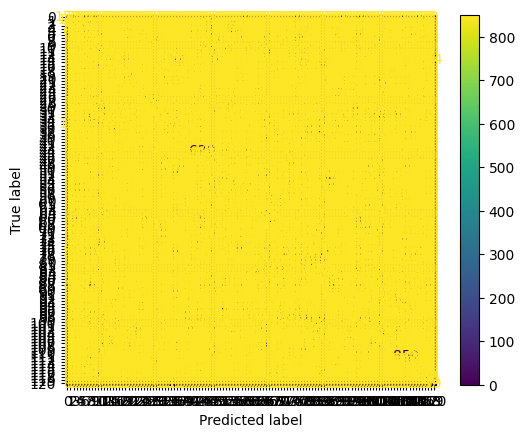

In [ ]:
ModelTrainer(
    train_dataset=fruits_hog_train_dataset,
    test_dataset=fruits_hog_test_dataset,
    estimator=XGBClassifier(random_state=42, eval_metric='logloss'),
    parameters_distribution={
        'n_estimators': [50, 100],
        'max_depth': [5, 7],
        'learning_rate': [0.05, 0.1],
    },
    model_name='xgb',
    dataset_name='fruits',
    cv=3
).results()